In [1]:
! nvidia-smi
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
import logging
from sklearn.metrics import classification_report, confusion_matrix
from time import time
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

tf.autograph.set_verbosity(0, False)
logging.getLogger("tensorflow").setLevel(logging.ERROR)

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
model = tf.keras.applications.EfficientNetB0(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

21848064/21834768 [==============================] - 0s 0us/step


In [7]:
from PIL import Image

img = Image.open("icecream.jpeg")
img.load()
data = np.asarray(img)
data = np.expand_dims(data, axis=0)
data.shape

(1, 224, 224, 3)

In [17]:
pred = model.predict(data)
max_args = (-pred).argsort()
max_args[0][:10]

array([928, 969, 927, 923, 961, 551, 960, 968, 438, 966])

# Finetuning

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# x_train = tf.image.resize(x_train, (224, 224))
# x_test = tf.image.resize(x_test, (224, 224))
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)

x_train: (50000, 32, 32, 3)
y_train: (50000, 1)


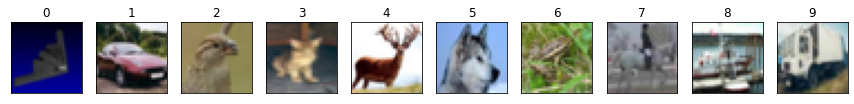

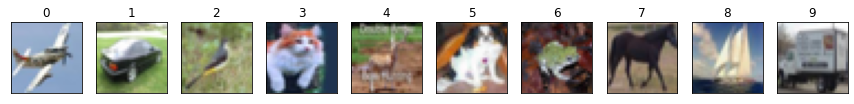

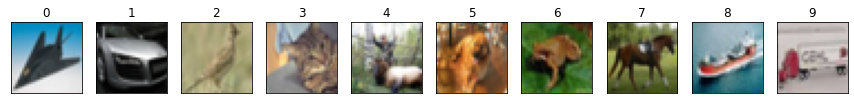

In [ ]:
def plot_pics(x: np.ndarray, y: np.ndarray):
    fig = plt.figure(figsize=(15, 4))
    for class_num in range(10):
        class_indices = np.where(y == class_num)[0]
        class_x = x[class_indices]
        rnd_idx = np.random.randint(len(class_x))
        image = class_x[rnd_idx]
        ax = fig.add_subplot(1, 10, class_num + 1, xticks=[], yticks=[])
        ax.set_title(class_num)
        plt.imshow(image)
    plt.show()

for i in range(3):
    plot_pics(x_train, y_train)

## Preprocessing

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input

def onehot(a):
    a = a.flatten()
    o = np.zeros((a.size, a.max() + 1))
    o[np.arange(a.size), a] = 1
    return o

def preprocess(x, y):
    assert x.shape[1:] == (32, 32, 3)
    assert y.shape[1:] == (1, )
    # x = x / 127.5 - 1.0  # normalize
    # x = x / 255.0
    # x = preprocess_input(x)
    y = onehot(y)  # onehot labels
    return x, y

x_train_processed, y_train_processed = preprocess(x_train, y_train)
x_test_processed, y_test_processed = preprocess(x_test, y_test)
x_train_processed.shape, y_train_processed.shape

((50000, 32, 32, 3), (50000, 10))

# Training

In [ ]:
class Trainer:
    def __init__(self, activation_function="relu", 
                 optimizer="adam", 
                 loss_function='categorical_crossentropy') -> None:
        self.optimizer = optimizer
        self.activation_function = activation_function
        self.loss_function = loss_function
        self.model = self.build_cnn_model()
        self.history = None
        self.training_time = None
        
    
    def print_summary(self):
        print("######################")
        print(f"Training Time: {self.training_time:.2f}s")
        print("batch size:", self.batch_size)
        print("optimizer:", self.optimizer)
        print("activation_function:", self.activation_function)
        print("loss_function", self.loss_function)
        print(self.model.summary())

    def build_cnn_model(self):
        model = tf.keras.applications.EfficientNetB0(
            include_top=False,
            weights="imagenet",
            input_tensor=tf.keras.layers.Resizing(224, 224)(tf.keras.Input(shape=(32, 32, 3)))
        )
        x = model.layers[-1].output
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(10, activation='softmax')(x)
        model = tf.keras.Model(inputs=model.inputs, outputs=x)

        model.compile(
            optimizer=self.optimizer,
            loss=self.loss_function,
            metrics=['accuracy']
        )
        return model
    
    def train(self, x_train, y_train, batch_size=32, epochs=50):
        self.batch_size = batch_size
        assert y_train.shape[1:] == (10, )
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            verbose=1,
            patience=4,
            mode='min',
            restore_best_weights=True
        )
        start = time()
        self.history = self.model.fit(
            x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_split=0.2,
            callbacks=[early_stopping],
        )
        self.training_time = time() - start
    
    def plot_history(self):
        fig = plt.figure(figsize=(12, 4))
        metrics = ['loss', 'accuracy']
        for n, metric in enumerate(metrics):
            plt.subplot(1, 2, n+1)
            plt.plot(self.history.epoch, self.history.history[metric], label='Train')
            plt.plot(self.history.epoch, self.history.history[f"val_{metric}"], linestyle="--", label='Validation')
            plt.xlabel('Epoch')
            plt.ylabel(metric)
            plt.title(metric)
        plt.legend()
        plt.show()
    
    def evaluate(self, x_test, y_test):
        assert y_test.shape[1:] == (10, )
        [test_loss,test_acc] = self.model.evaluate(x_test,y_test)
        print("Test Loss:", test_loss, "Test Accuracy:", test_acc)
        test_preds = np.argmax(self.model.predict(x_test), axis=-1)
        y_test = np.argmax(y_test, axis=-1)
        print(classification_report(y_test, test_preds))
        self.plot_cm(y_test, test_preds)
    
    def plot_cm(self, y_true, preds):
        cm = confusion_matrix(y_true, preds)
        plt.figure(figsize=(7, 5))
        ax = sns.heatmap(cm, annot=True, fmt="d")
        bottom, top = ax.get_ylim()
        ax.set_ylim(bottom + 0.5, top - 0.5)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

In [ ]:
trainer = Trainer(
    activation_function="relu", 
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), 
)
trainer.train(x_train_processed, y_train_processed, 
              batch_size=128, 
              epochs=1)
trainer.print_summary()
trainer.plot_history()
trainer.evaluate(x_test_processed, y_test_processed)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 resizing (Resizing)            (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['resizing[0][0]']               
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                              